### Лабораторная работа №7. Рекуррентные нейронные сети для анализа текста

Данные: Набор данных для предсказания оценок для отзывов, собранных с сайта imdb.com, который состоит из 50,000 отзывов в виде текстовых файлов. Отзывы разделены на положительные (25,000) и отрицательные (25,000). Данные предварительно токенизированы по принципу “мешка слов”, индексы слов можно взять из словаря (imdb.vocab). 

Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов, а также. Данные можно скачать по ссылке https://ai.stanford.edu/~amaas/data/sentiment/

Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?

Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?

Задание 4.
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?

Задание 5.
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).

Какой максимальный результат удалось получить на контрольной выборке?
Результат выполнения заданий опишите в отчете.

In [1]:
!pip install tensorflow-datasets

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


Приводим все к одному размеру: используем zero-padding справа до длины максимального предложения в батче

In [6]:
TRAIN_BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(TRAIN_BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], []))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64), merge_mode='concat'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         818500    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               63744     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 890,565
Trainable params: 890,565
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=100,
    validation_steps=30,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
196/196 [==============================] - 38s 194ms/step - loss: 0.5801 - accuracy: 0.6783 - val_loss: 0.4320 - val_accuracy: 0.8089
Epoch 2/100
196/196 [==============================] - 34s 172ms/step - loss: 0.3337 - accuracy: 0.8629 - val_loss: 0.3732 - val_accuracy: 0.8492
Epoch 3/100
196/196 [==============================] - 33s 170ms/step - loss: 0.2366 - accuracy: 0.9085 - val_loss: 0.3821 - val_accuracy: 0.8471
Epoch 4/100
196/196 [==============================] - 33s 169ms/step - loss: 0.1892 - accuracy: 0.9310 - val_loss: 0.3927 - val_accuracy: 0.8570
Epoch 5/100
196/196 [==============================] - 33s 169ms/step - loss: 0.1472 - accuracy: 0.9476 - val_loss: 0.4575 - val_accuracy: 0.8409
Epoch 6/100
196/196 [==============================] - 33s 167ms/step - loss: 0.1389 - accuracy: 0.9496 - val_loss: 0.4983 - val_accuracy: 0.8516
Epoch 7/100
196/196 [==============================] - 33s 168ms/step - loss: 0.0912 - accuracy: 0.9701 - val_loss: 0.5371 -

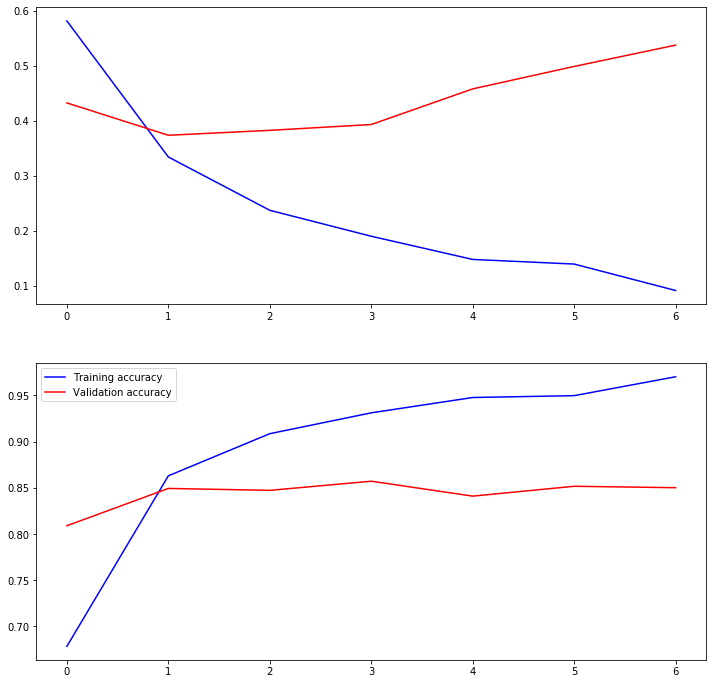

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()

### More layers

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True), merge_mode='concat'),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64), merge_mode='concat'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=100,
    validation_steps=30,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
196/196 [==============================] - 62s 315ms/step - loss: 0.7284 - accuracy: 0.5837 - val_loss: 0.5868 - val_accuracy: 0.6948
Epoch 2/100
196/196 [==============================] - 55s 280ms/step - loss: 0.6587 - accuracy: 0.6804 - val_loss: 0.6503 - val_accuracy: 0.6143
Epoch 3/100
196/196 [==============================] - 55s 281ms/step - loss: 0.5780 - accuracy: 0.7331 - val_loss: 0.6111 - val_accuracy: 0.6630
Epoch 4/100
196/196 [==============================] - 55s 279ms/step - loss: 0.6056 - accuracy: 0.7287 - val_loss: 0.8945 - val_accuracy: 0.6641
Epoch 5/100
196/196 [==============================] - 56s 284ms/step - loss: 0.5449 - accuracy: 0.7669 - val_loss: 0.6654 - val_accuracy: 0.6456
Epoch 6/100
196/196 [==============================] - 55s 282ms/step - loss: 0.4996 - accuracy: 0.7978 - val_loss: 0.9723 - val_accuracy: 0.6378


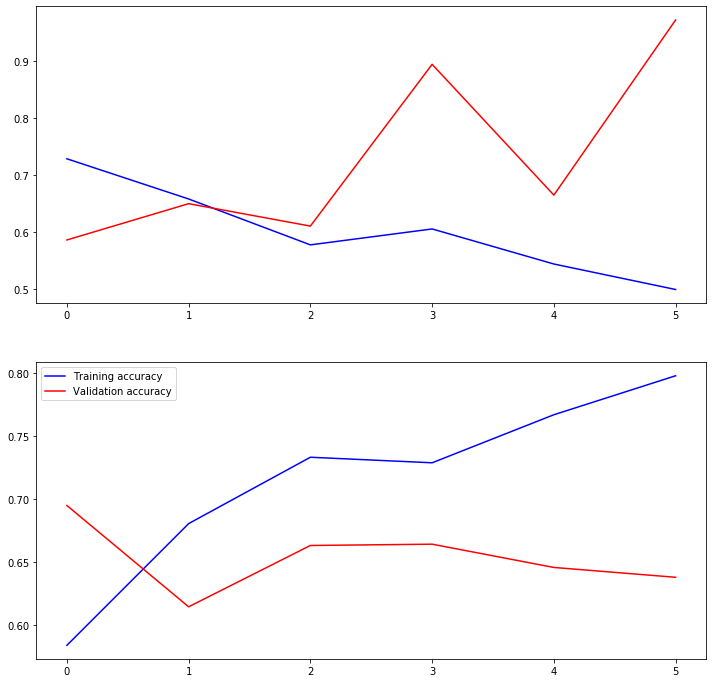

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()

Сильный оверфит

### Pretrained GLOVE vectors

In [13]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2020-04-15 23:20:56--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-04-15 23:20:56--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-04-15 23:20:57--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [14]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [24]:
embeddings_index = {}
with open("glove.840B.300d.txt", "r") as in_file:
    for line in in_file:
        values = line.split()
        
        try:
            word = values[0]
            embeddings_index[word] = np.asarray(values[1:], dtype=np.float32)
        except:
            pass

In [62]:
len(embeddings_index)

2195884

In [63]:
embedding_matrix = np.zeros((encoder.vocab_size, 300))

# 0 is used for padding in Keras
for index, word in enumerate(encoder.subwords, 1):
    word = word.lower()
    
    # lives_ ==> lives
    if word.endswith("_"):
        word = word[:-1]

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 300, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True), merge_mode='concat'),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64), merge_mode='concat'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=100,
    validation_steps=30,
    validation_data=test_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
196/196 [==============================] - 57s 289ms/step - loss: 0.7962 - accuracy: 0.5326 - val_loss: 0.6758 - val_accuracy: 0.5786
Epoch 2/100
196/196 [==============================] - 53s 271ms/step - loss: 0.7062 - accuracy: 0.5712 - val_loss: 0.6693 - val_accuracy: 0.5857
Epoch 3/100
196/196 [==============================] - 52s 266ms/step - loss: 0.6592 - accuracy: 0.6169 - val_loss: 0.5938 - val_accuracy: 0.6677
Epoch 4/100
196/196 [==============================] - 53s 271ms/step - loss: 0.6694 - accuracy: 0.6699 - val_loss: 0.4856 - val_accuracy: 0.8010
Epoch 5/100
196/196 [==============================] - 53s 270ms/step - loss: 0.6115 - accuracy: 0.7554 - val_loss: 1.2093 - val_accuracy: 0.5023
Epoch 6/100
196/196 [==============================] - 52s 267ms/step - loss: 0.6299 - accuracy: 0.7228 - val_loss: 0.5106 - val_accuracy: 0.7883
Epoch 7/100
196/196 [==============================] - 53s 272ms/step - loss: 0.5420 - accuracy: 0.7784 - val_loss: 0.4731 -

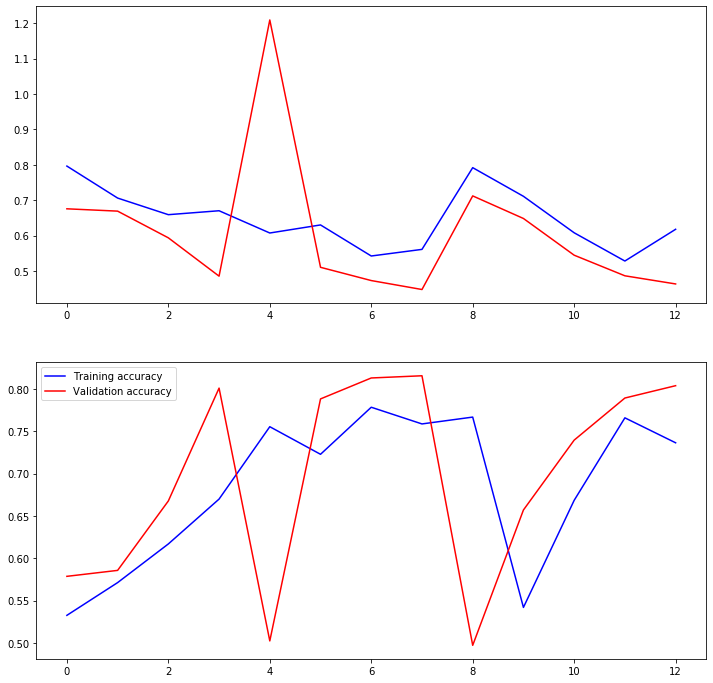

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()

Достигнуто лучшее качество и обобщаяющая способность, прыжки в скоре скорее всего связаны со слишком большим шагом обучения